## Real Spacers sequence features
(See fetch_real_data.ipynb prior to this notebook for getting and indexing the actual spacers).  

In our benchmark, we'll use the CRISPR sapcer set from iphop [https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions](https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions) (June 2025 upload).  
Despite being considered as a more curated set compared to the IMG/VR4 set (e.g. the size range is 25-50, with no spacers over 100bp), we will still inspect it for potential issues.  
Doing this we can also get an idea on the features of real spacers:
-  low complexity sequences (low shannon entropy, low lcc value, presence of dustmasked/ambiguous bases...)
-  Relative base composition
-  distribution of kmers (uniqueness and repeatability, 2<= k <= 6)
-  per position base frequency

Using these features, we can filter out certain sequences that some tools (like iphop) would have filter out in post-processing (after spacer-protospacer matching). While some tools have defaults and heuristics to filter out low complexity or repetitive sequences, so by doing this prior to the benchmark we are potentially skewing the results in favor of tools that do not have these filters (although some tools were specifically benchmarked with CLI options to avoid these filters - e.g. the blastn "short" task has dust filtering turned off by default).  
These low quality spacers could be the results of the extraction tools (like pilercr and CRT) misdetecting non-CRISPR repeat sequences, or potentially not extracting the sequences correctly.


In [4]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/') # needed as it's easier to use relative paths without ../ everytime.
import json
import polars as pl
import pydustmasker as pdm
import matplotlib.pyplot as plt
import seaborn as sns
from bench import *
from bench.utils.functions import  read_fasta_needletail, calculate_shannon_entropy, count_kmers_df, lcc_simp, lcc_mult, filter_repetitive_kmers

pl.Config(tbl_rows=50)
plots_dir = '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/'
# Load your custom color palette
with open('../notebooks/antonio_14_colors.json', 'r') as f:
    color_data = json.load(f)
# Set the color palette globally
custom_colors = color_data['hex_colors']
sns.set_palette(custom_colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
    
spacers_file = 'spacers/All_CRISPR_spacers_nr_clean.fna'
spacer_df = pl.DataFrame(read_fasta_needletail(spacers_file), schema={'seqid': pl.Utf8, 'seq': pl.Utf8},)
spacer_df = spacer_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"))

### Some basics
First, let's see the total size of the set and the ranges of lengths and GC content.

Total number of spacers: 3882812
Length range: 25 - 40
Length mean: 33.85102008544323
GC content range: 0.025 - 0.9743589743589743
GC content mean: 0.47643802837439486


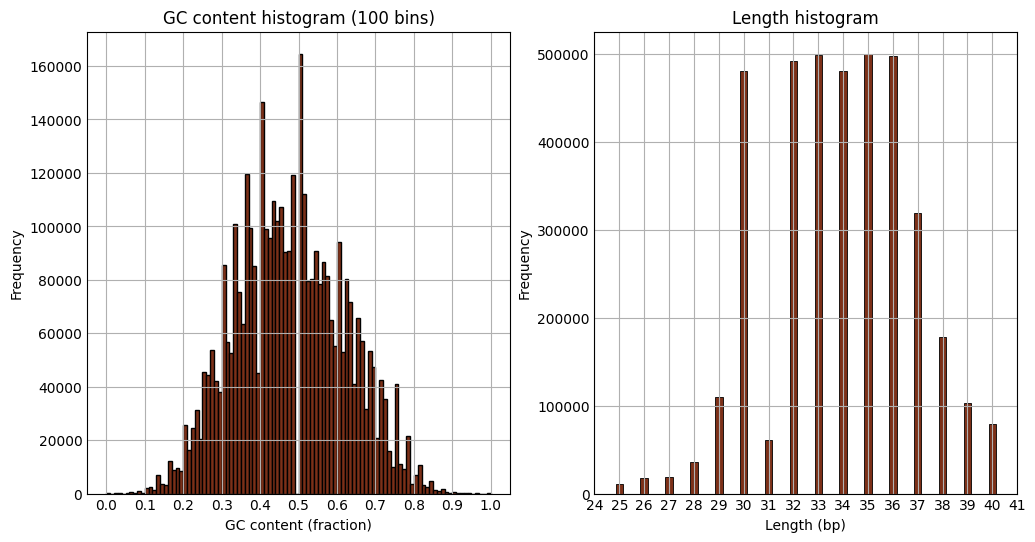

In [5]:
print(f"Total number of spacers: {spacer_df.height}")
print(f"Length range: {spacer_df['length'].min()} - {spacer_df['length'].max()}")
print(f"Length mean: {spacer_df['length'].mean()}")
print(f"GC content range: {spacer_df.filter(pl.col('gc_frac') > 0)['gc_frac'].min()} - {spacer_df.filter(pl.col('gc_frac') != 1)['gc_frac'].max()}")
print(f"GC content mean: {spacer_df.filter(pl.col('gc_frac') > 0)['gc_frac'].mean()}")
spacer_df["gc_frac"].describe()

# quick plots   - two panels, one for the GC content and one for the length
length_bins = np.arange(25, 42, 1)
gc_bins = np.arange(0, 1.01, 0.01)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(spacer_df["gc_frac"], bins=gc_bins, edgecolor='black')
axes[0].set_title('GC content histogram (100 bins)')
axes[0].set_xlabel('GC content (fraction)')
axes[0].set_ylabel('Frequency')
# axes[1].hist(spacer_df["length"], bins=length_bins, edgecolor='black', linewidth=0.2, rwidth=0.8)
axes[1].hist(spacer_df["length"], bins=length_bins, edgecolor='black', linewidth=0.6, rwidth=0.3, align='left')
axes[1].set_title('Length histogram')
axes[1].set_xlabel('Length (bp)')
axes[1].set_ylabel('Frequency')
# show grid
axes[0].grid(True)
axes[1].grid(True)
# show ticks for all x values
axes[0].set_xticks([gc_bins[i] for i in range(0, 101, 10)])
axes[1].set_xticks(spacer_df["length"].unique().to_list() + [24,41])
# set the y axis to log and show the ticks
# axes[1].set_yscale('log')
# axes[1].set_yticks([10**i for i in range(0, 7)])

# show ticks labels
axes[0].tick_params(axis='both', which='both', length=0)
axes[1].tick_params(axis='both', which='both', length=0)
plt.savefig(plots_dir + 'gc_length_distributions.svg')
plt.show()

### Relative base composition of the spacers (fraction of the each base out of the total number of bases in each spacer).

In [7]:
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("N|n")/pl.col("length")).alias("n_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t")/pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c")/pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g")/pl.col("length")).alias("g_frac"),
)
# spacer_df = spacer_df.sort("t_frac", descending=True)

### Plots 

a_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.261702   │
│ std        ┆ 0.107613   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.181818   │
│ 50%        ┆ 0.25       │
│ 75%        ┆ 0.333333   │
│ max        ┆ 1.0        │
└────────────┴────────────┘


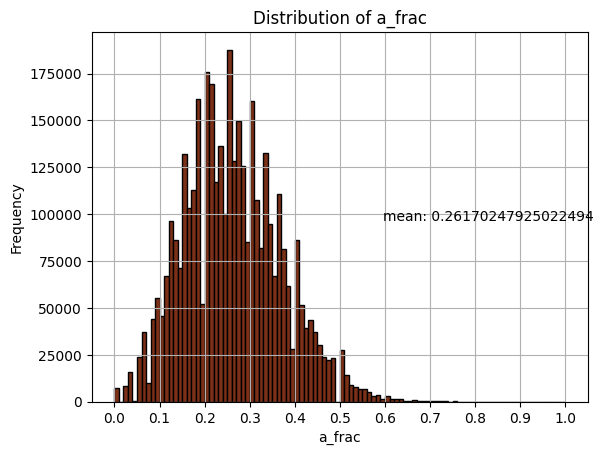

t_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.261751   │
│ std        ┆ 0.107737   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.181818   │
│ 50%        ┆ 0.25       │
│ 75%        ┆ 0.333333   │
│ max        ┆ 0.933333   │
└────────────┴────────────┘


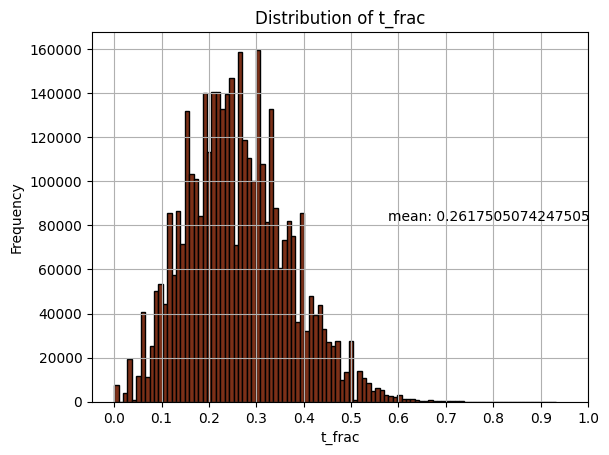

c_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.238359   │
│ std        ┆ 0.096436   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.166667   │
│ 50%        ┆ 0.233333   │
│ 75%        ┆ 0.30303    │
│ max        ┆ 0.92       │
└────────────┴────────────┘


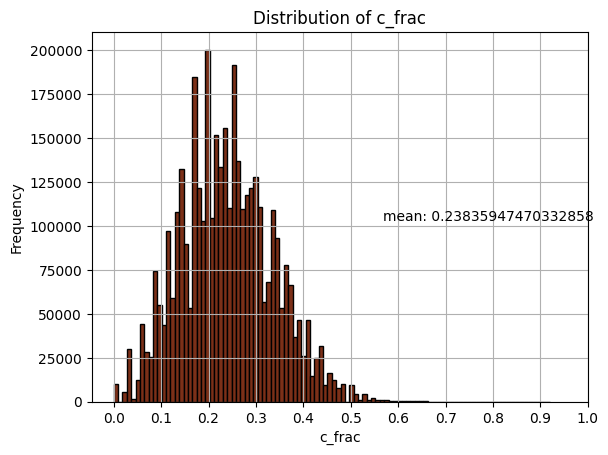

g_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.238039   │
│ std        ┆ 0.09656    │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.166667   │
│ 50%        ┆ 0.233333   │
│ 75%        ┆ 0.30303    │
│ max        ┆ 1.0        │
└────────────┴────────────┘


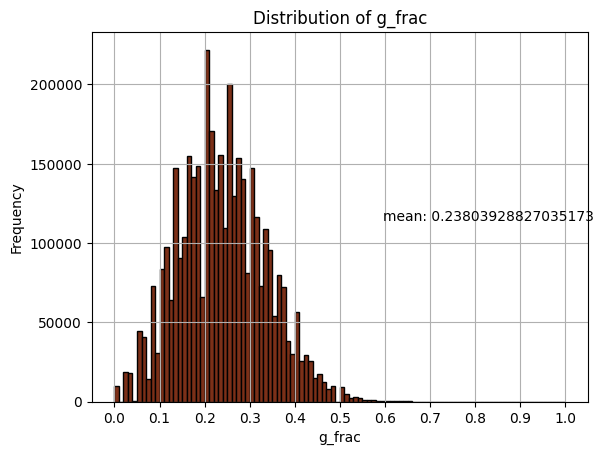

n_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.000147   │
│ std        ┆ 0.010133   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.0        │
│ 50%        ┆ 0.0        │
│ 75%        ┆ 0.0        │
│ max        ┆ 1.0        │
└────────────┴────────────┘


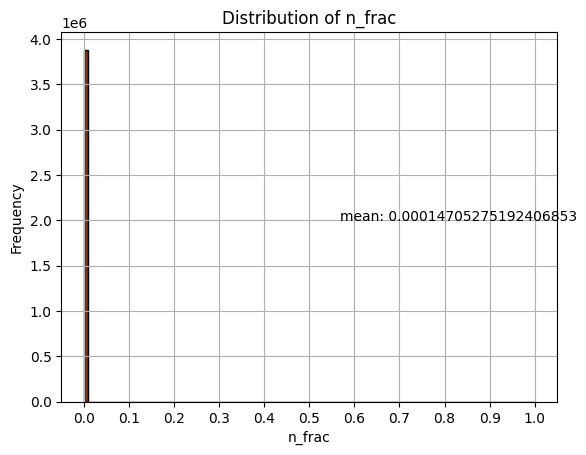

In [10]:
for base in ["a_frac", "t_frac", "c_frac", "g_frac", "n_frac"]:
    print(f"{base} stats:")
    print(spacer_df[base].describe())
    plt.hist(spacer_df[base], bins=100, edgecolor='black')
    plt.title(f'Distribution of {base}')
    # show grid
    plt.grid(True)
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(base)
    plt.ylabel('Frequency')
    plt.text(0.8, 0.5, f'mean: {spacer_df[base].mean()}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.savefig(plots_dir + f'{base}_distribution.svg')
    plt.show()
    plt.close()


### Ambiguous base presence
The N fraction from above is small but not 0. as a precaution, we'll mark these with a column.


In [11]:
spacer_df = spacer_df.with_columns(
    pl.when(pl.col("n_frac") > 0).then(True).otherwise(False).alias("has_n"))
spacer_df["has_n"].value_counts(normalize=True)

has_n,proportion
bool,f64
false,0.999675
true,0.000325


### Shannon entropy
Calculating the Shannon entropy of each spacer sequence.  

The Shannon entropy formula for an entire sequenceis $H = -\sum p_{i}\log _{2}p_{i}$   
where $p_{i}$ is the probability of character $i$ in the spacer sequence.


In [12]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)
spacer_df["entropy"].describe()

statistic,value
str,f64
"""count""",3.882812e6
"""null_count""",0.0
"""mean""",1.872601
"""std""",0.107339
"""min""",0.0
"""25%""",1.825323
"""50%""",1.900292
"""75%""",1.948929
"""max""",3.253259


An plotting the histogram of the entropy values to see the distribution.

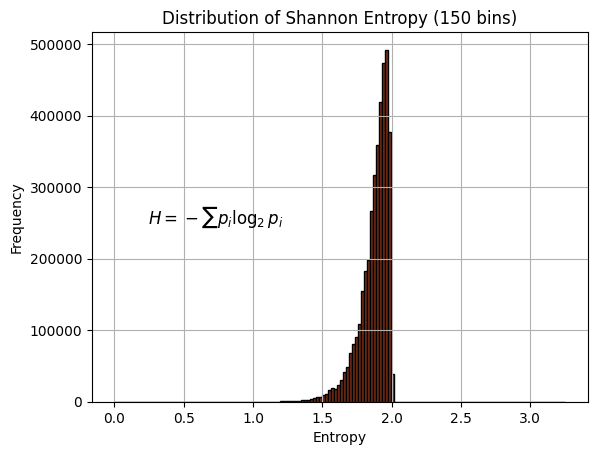

In [13]:
plt.grid(True)
plt.hist(spacer_df["entropy"], bins=150, edgecolor='black')
plt.title('Distribution of Shannon Entropy (150 bins)')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.text(0.25, 0.5, '$H = -\sum p_{i}\log_{2} p_{i}$', ha='center', va='center', transform=plt.gca().transAxes,fontsize=12)
plt.savefig(plots_dir + 'entropy_distribution.svg')
plt.show()

### Reapeted kmer compositions

The Shannon entrophy metric doesn't take into account the base order: `aaaaaatttttttgggggcccccc` and `ccccattaaaacggcgttgtgatt` will have the same value, even thouse the first one is less complex.  
Because of this, we'll examine if the spacers contain repeatative (appearing at least twice) substrings of lengths 3-8. For the example above, if we use k=3, we get:
| seq | kmer_3_counts |
|-----|---------------|
| `aaaaaatttttttgggggcccccc` | `aat': 1,tgg: 1,ggg: 3,aaa: 4,ttg: 1,ccc: 4,ttt: 5,gcc: 1,att: 1,ggc: 1` |
| `ccccattaaaacggcgttgtgatt` | `ccc: 2,att: 2,aaa: 2,cca: 1,cat: 1,tta: 1,taa: 1,aac: 1,acg: 1,cgg: 1,ggc: 1,gcg: 1,cgt: 1,gtt: 1,ttg: 1,tgt: 1,gtg: 1,tga: 1,gat: 1` |
  
And the mean of the counts for the first is:
$\frac{1 + 1 + 3 + 4 + 1 + 4 + 5 + 1 + 1 + 1}{10} = \frac{22}{10} = 2.2$  
And for the second:
$\frac{2 + 2 + 2 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 }{19} = \frac{22}{19} = 1.157895$  

*Notice* the **denominator** is larger for the second sequence, as there are more unique 3mers.

<!-- 
# import random
example_seq = "aaaaaatttttttgggggcccccc"
# new_seq = "".join(random.sample(example_seq, len(example_seq))) # only needed this to run once
new_seq ="ccccattaaaacggcgttgtgatt"
seq_df = pl.DataFrame({"seq": [example_seq, new_seq], "seqid": ["example_seq", "new_seq"]})
seq_df = seq_df.with_columns(   
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)
seq_df = count_kmers_df(seq_df, "seq", "seqid", 3, relative=False)
seq_df = seq_df.with_columns(
    pl.col('kmer_3_counts').list.eval(
        pl.element().struct.field('count').mean()
    ).alias("mean_kmer_3_counts")
)

print(seq_df)
#  kmer_3_counts so the table has two columns: "count" and "kmer"
# Create the kmer table by exploding and unnesting properly
kmer_table = seq_df.select(
    pl.col("seqid"),
    pl.col("kmer_3_counts")
).explode("kmer_3_counts").unnest("kmer_3_counts").rename({"substrings": "kmer"})

print("\nK-mer table with count and kmer columns:")
print(kmer_table) -->

So next, we will to the table columns with the 3-7mers counts, to get an idea of the repeateveness of the spacers.

In [15]:
%%time
for k in range(2, 8):
    tmp_df = count_kmers_df_explicit(spacer_df, "seq", "seqid", k, relative=False)
    # extracting the mean, n_unique, and sum of the counts
    tmp_df = tmp_df.select(
        pl.col(f"kmer_{k}_counts").list.eval(
            pl.element().struct.field("count").mean()
        ).list.first().alias(f"avg_kmer_{k}"),
        pl.col(f"kmer_{k}_counts").list.eval(
            pl.element().struct.field("kmers").n_unique()
        ).list.first().alias(f"n_unique_kmer_{k}"),
        pl.col(f"kmer_{k}_counts").list.eval(
            pl.element().struct.field("count").sum()
        ).list.first().alias(f"sum_kmer_{k}")
    )
    spacer_df = spacer_df.with_columns(
        tmp_df[f"avg_kmer_{k}"].alias(f"avg_kmer_{k}"),
        tmp_df[f"n_unique_kmer_{k}"].alias(f"n_unique_kmer_{k}"),
        tmp_df[f"sum_kmer_{k}"].alias(f"sum_kmer_{k}")
    )
    del tmp_df # this can get big, and python GC won't know we treat it as a tmp variable...
    print(f"k={k} done")
spacer_df 

k=2 done
k=3 done
k=4 done
k=5 done
k=6 done
k=7 done
CPU times: user 27min 54s, sys: 24min 39s, total: 52min 33s
Wall time: 2min 40s


seqid,seq,length,gc_frac,n_frac,a_frac,t_frac,c_frac,g_frac,has_n,entropy,avg_kmer_2,n_unique_kmer_2,sum_kmer_2,avg_kmer_3,n_unique_kmer_3,sum_kmer_3,avg_kmer_4,n_unique_kmer_4,sum_kmer_4,avg_kmer_5,n_unique_kmer_5,sum_kmer_5,avg_kmer_6,n_unique_kmer_6,sum_kmer_6,avg_kmer_7,n_unique_kmer_7,sum_kmer_7
str,str,u32,f64,f64,f64,f64,f64,f64,bool,f64,f64,u32,u32,f64,u32,u32,f64,u32,u32,f64,u32,u32,f64,u32,u32,f64,u32,u32
"""3300001746_1:JGI24672J20091_10…","""GACCGCTCGTAAAACCCTTCACGCATACGA…",35,0.485714,0.0,0.342857,0.171429,0.342857,0.142857,false,1.896183,2.692308,13,35,1.137931,29,33,1.08,25,27,1.0,26,26,1.15,20,23,1.0,27,27
"""3300001746_1:JGI24672J20091_10…","""TTGTAGCGACCGCCATAACGGGCCGCATTT…",35,0.542857,0.0,0.2,0.257143,0.314286,0.228571,false,1.979724,2.071429,14,29,1.631579,19,31,1.033333,30,31,1.0,30,30,1.0,24,24,1.0,30,30
"""3300001746_1:JGI24672J20091_10…","""CAATTATCTGGGTGTCCCGGCAGGTGATTA…",36,0.5,0.0,0.222222,0.277778,0.194444,0.305556,false,1.977577,2.214286,14,31,1.185185,27,32,1.034483,29,30,1.142857,28,32,1.0,35,35,1.0,28,28
"""3300001746_1:JGI24672J20091_10…","""ACGCCGGTCCCACCATGGGCCACCGGAACA…",35,0.657143,0.0,0.228571,0.114286,0.4,0.257143,false,1.876932,2.230769,13,29,1.217391,23,28,1.153846,26,30,1.071429,28,30,1.0,28,28,1.0,28,28
"""3300001746_1:JGI24672J20091_10…","""GCCACCGGACATGCTGTACGAAAAGTACCC…",34,0.529412,0.0,0.294118,0.176471,0.294118,0.235294,false,1.971335,2.071429,14,29,1.192308,26,31,1.064516,31,33,1.0,35,35,1.0,28,28,1.0,30,30
"""3300003129_2:Ga0052190_100957:…","""ACAGATGACAGATGTCAGAGAACAGATGAC…",36,0.416667,0.0,0.444444,0.138889,0.138889,0.277778,false,1.824409,2.428571,14,34,1.333333,21,28,1.0,29,29,1.0,28,28,1.0,28,28,1.0,30,30
"""3300003129_2:Ga0052190_100957:…","""ACGGATAACAGAGAACAGACTACAGACGA""",29,0.448276,0.0,0.482759,0.068966,0.206897,0.241379,false,1.738525,2.428571,14,34,1.333333,21,28,1.03125,32,33,1.066667,30,32,1.0,28,28,1.0,26,26
"""3300003129_2:Ga0052190_100957:…","""ACAGAGCACAGATGTCAGACGACAGATGAC…",36,0.472222,0.0,0.388889,0.138889,0.194444,0.277778,false,1.898165,2.75,12,33,1.148148,27,31,1.0,27,27,1.035714,28,29,1.0,30,30,1.0,33,33
"""3300003129_2:Ga0052190_102205:…","""CTTCGACAATCAAAGCAACTACATAAATCC…",38,0.421053,0.0,0.394737,0.184211,0.289474,0.131579,false,1.881658,2.428571,14,34,1.458333,24,35,1.066667,30,32,1.0,33,33,1.0,25,25,1.0,27,27


saving it for later use (no need to re-run the kmer counting)

In [17]:
spacer_df.write_parquet("/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/spacers/spacers_with_kmer_counts.parquet")

In [ ]:
# asdasd

NameError: name 'asdasd' is not defined

### plots (uniqueness and repeatability of kmer counts vs kmer length)

In [18]:
#first transform the data to long format
kmer_df = spacer_df.select(
    pl.col("seqid"),
    pl.col("n_unique_kmer_2"),
    pl.col("sum_kmer_2"),
    pl.col("n_unique_kmer_3"),
    pl.col("sum_kmer_3"),
    pl.col("n_unique_kmer_4"),
    pl.col("sum_kmer_4"),
    pl.col("n_unique_kmer_5"),
    pl.col("sum_kmer_5"),
    pl.col("n_unique_kmer_6"),
    pl.col("sum_kmer_6"),
    pl.col("n_unique_kmer_7"),
    pl.col("sum_kmer_7")
)
# Reshape data for plotting - convert to long format # TODO: think of a  programmatic way to do this (instead of explicitly writing out each kmer length)
kmer_long = pl.concat([
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_2").alias("n_unique"),
        pl.col("sum_kmer_2").alias("sum_kmer"),
        pl.lit(2).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_3").alias("n_unique"),
        pl.col("sum_kmer_3").alias("sum_kmer"),
        pl.lit(3).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_4").alias("n_unique"),
        pl.col("sum_kmer_4").alias("sum_kmer"),
        pl.lit(4).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_5").alias("n_unique"),
        pl.col("sum_kmer_5").alias("sum_kmer"),
        pl.lit(5).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_6").alias("n_unique"),
        pl.col("sum_kmer_6").alias("sum_kmer"),
        pl.lit(6).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_7").alias("n_unique"),
        pl.col("sum_kmer_7").alias("sum_kmer"),
        pl.lit(7).alias("k_length")
    ])
])

# Calculate mean k-mer counts
kmer_long = kmer_long.with_columns(
    (pl.col("sum_kmer") / pl.col("n_unique")).alias("mean_kmer")
)

print("Reshaped data shape:", kmer_long.shape)
kmer_long.head()


Reshaped data shape: (23296872, 5)


seqid,n_unique,sum_kmer,k_length,mean_kmer
str,u32,u32,i32,f64
"""3300001746_1:JGI24672J20091_10…",13,35,2,2.692308
"""3300001746_1:JGI24672J20091_10…",14,29,2,2.071429
"""3300001746_1:JGI24672J20091_10…",14,31,2,2.214286
"""3300001746_1:JGI24672J20091_10…",13,29,2,2.230769
"""3300001746_1:JGI24672J20091_10…",14,29,2,2.071429


Some box plots for k-mer statistics

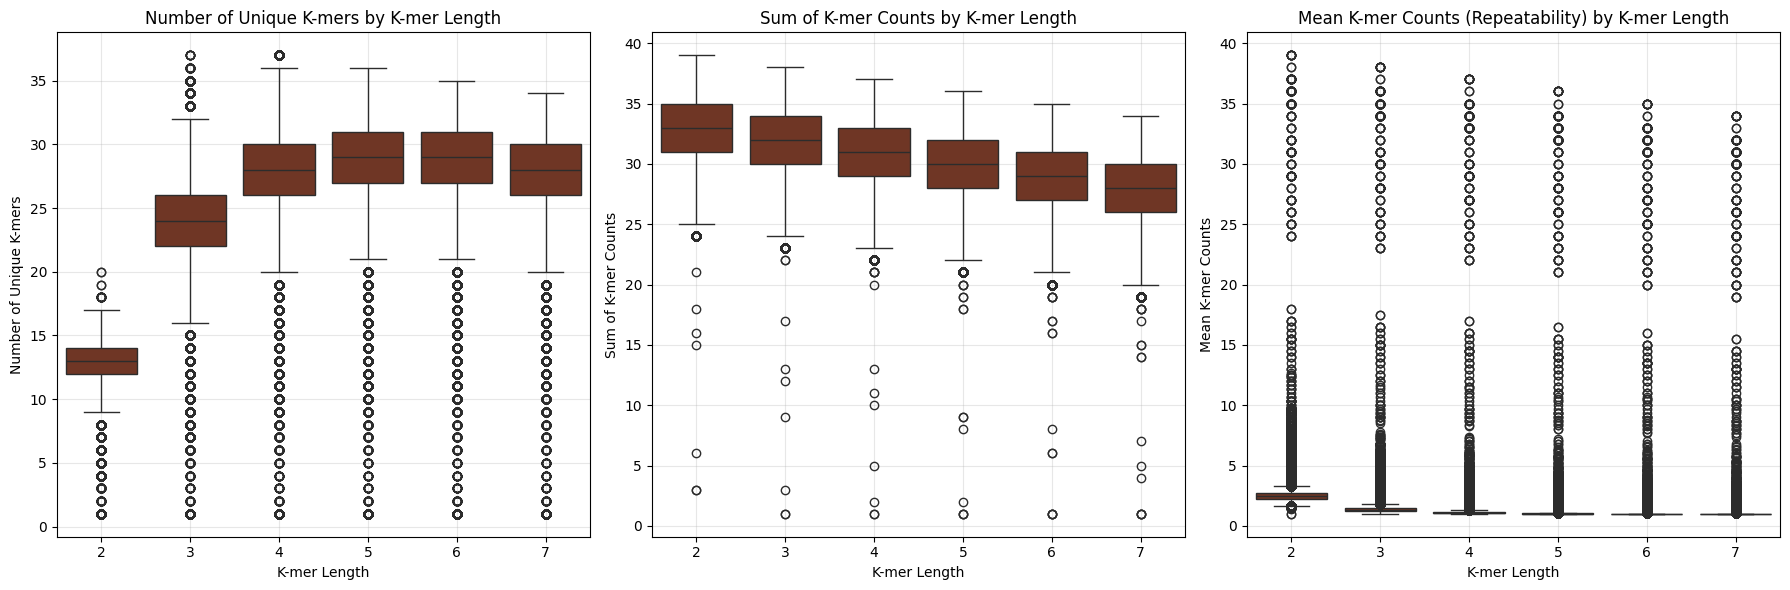

Plot saved to: /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/kmer_statistics_boxplots.svg


<Figure size 640x480 with 0 Axes>

In [19]:
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Number of unique k-mers
sns.boxplot(data=kmer_long, x='k_length', y='n_unique', ax=axes[0])
axes[0].set_title('Number of Unique K-mers by K-mer Length')
axes[0].set_xlabel('K-mer Length')
axes[0].set_ylabel('Number of Unique K-mers')
axes[0].grid(True, alpha=0.3)

# Plot 2: Sum of k-mer counts
sns.boxplot(data=kmer_long, x='k_length', y='sum_kmer', ax=axes[1])
axes[1].set_title('Sum of K-mer Counts by K-mer Length')
axes[1].set_xlabel('K-mer Length')
axes[1].set_ylabel('Sum of K-mer Counts')
axes[1].grid(True, alpha=0.3)

# Plot 3: Mean k-mer counts (repeatability)
sns.boxplot(data=kmer_long, x='k_length', y='mean_kmer', ax=axes[2])
axes[2].set_title('Mean K-mer Counts (Repeatability) by K-mer Length')
axes[2].set_xlabel('K-mer Length')
axes[2].set_ylabel('Mean K-mer Counts')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(f'{plots_dir}kmer_statistics_boxplots.svg', dpi=300, bbox_inches='tight')
print(f"Plot saved to: {plots_dir}kmer_statistics_boxplots.svg")


In [20]:
# Summary statistics for k-mer analysis
print("Summary statistics by k-mer length:")

summary_stats = kmer_long.group_by("k_length").agg([
    pl.col("n_unique").mean().alias("mean_n_unique"),
    pl.col("n_unique").std().alias("std_n_unique"),
    pl.col("sum_kmer").mean().alias("mean_sum_kmer"),
    pl.col("sum_kmer").std().alias("std_sum_kmer"),
    pl.col("mean_kmer").mean().alias("mean_repeatability"),
    pl.col("mean_kmer").std().alias("std_repeatability")
]).sort("k_length")

print(summary_stats)

# Calculate theoretical maximum unique k-mers for each k
print("\nTheoretical maximum unique k-mers (4^k):")
for k in range(2, 8):
    max_unique = 4**k
    print(f"k={k}: {max_unique}")

# Calculate actual vs theoretical ratios
print("\nActual vs Theoretical ratios (mean):")
for k in range(2, 8):
    actual_mean = summary_stats.filter(pl.col("k_length") == k)["mean_n_unique"][0]
    theoretical_max = 4**k
    ratio = actual_mean / theoretical_max
    print(f"k={k}: {ratio:.4f} ({actual_mean:.1f}/{theoretical_max})")


Summary statistics by k-mer length:
shape: (6, 7)
┌──────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┐
│ k_length ┆ mean_n_uniqu ┆ std_n_unique ┆ mean_sum_kme ┆ std_sum_kmer ┆ mean_repeat ┆ std_repeata │
│ ---      ┆ e            ┆ ---          ┆ r            ┆ ---          ┆ ability     ┆ bility      │
│ i32      ┆ ---          ┆ f64          ┆ ---          ┆ f64          ┆ ---         ┆ ---         │
│          ┆ f64          ┆              ┆ f64          ┆              ┆ f64         ┆ f64         │
╞══════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╡
│ 2        ┆ 13.181125    ┆ 1.603478     ┆ 32.850961    ┆ 2.838648     ┆ 2.530233    ┆ 0.446301    │
│ 3        ┆ 23.554717    ┆ 3.288511     ┆ 31.850947    ┆ 2.838695     ┆ 1.375964    ┆ 0.313012    │
│ 4        ┆ 28.053252    ┆ 3.307944     ┆ 30.850939    ┆ 2.838717     ┆ 1.110039    ┆ 0.258401    │
│ 5        ┆ 28.93481     ┆ 3.082219     

Will use LCC from biopython (https://github.com/biopython/biopython/blob/e451db211bdd855a5d0f1f6bba18985ffee12696/Bio/SeqUtils/lcc.py)

In [38]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: lcc_simp(x), return_dtype=pl.Float64).alias("lcc")
)
spacer_df["lcc"].describe()


statistic,value
str,f64
"""count""",3.882812e6
"""null_count""",0.0
"""mean""",0.936244
"""std""",0.053711
"""min""",0.0
"""25%""",0.912662
"""50%""",0.950146
"""75%""",0.974465
"""max""",1.0


### "Dust" masking


Adding a column for the number of masked bases in a spacer when using pydustmasker with a window size of 5 and a score threshold of 6.

In [39]:
score_threshold = 15
window_size = 9
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=window_size, score_threshold=score_threshold).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked")
    )
spacer_df["low_compx_n_masked"].value_counts().sort(by="low_compx_n_masked", descending=True)

low_compx_n_masked,count
i64,u32
38,1
36,1
35,2
34,2
33,5
31,3
30,2
29,5
28,9


And plots

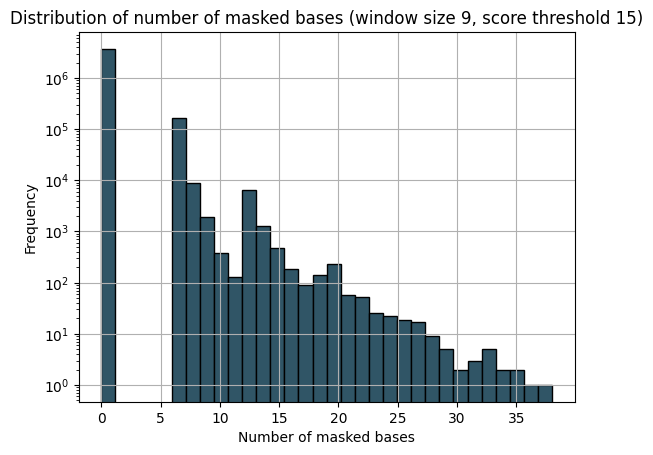

In [41]:
# histogram number of masked bases
plt.grid(True)
plt.hist(spacer_df["low_compx_n_masked"], bins=spacer_df["low_compx_n_masked"].n_unique(), edgecolor='black',log=True, color=custom_colors[4])
plt.title(f'Distribution of number of masked bases (window size {window_size}, score threshold {score_threshold})')
plt.xlabel('Number of masked bases')
plt.ylabel('Frequency')
plt.show()


For comparisson, we'll simulate 100k spacers of the same length and GC range via our rust_simulater 

In [27]:
%%bash
spacer_bencher simulate --num-spacers 100000 --gc-content 50 --spacer-insertions 1 1 --num-contigs 10000 --spacer-length 25 40 --mismatch-range 0 5 --output-dir tmp/simulated_spacers --spacer-distribution uniform --threads 4

[11/03/25 17:44:34] INFO     Starting simulation with 100000 spacers  ]8;id=739604;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/cli.py\cli.py]8;;\:]8;id=289111;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/cli.py#157\157]8;;\
                             and 10000 contigs                                  
[11/03/25 17:44:34] INFO     Starting simulation: 10000 contigs,  ]8;id=909657;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/simulate.py\simulate.py]8;;\:]8;id=667880;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/simulate.py#47\47]8;;\
                             100000 spacers                                     
[11/03/25 17:44:34] INFO     Running Rust simulator...            ]8;id=735396;file:///clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/src/bench/commands/simulate.py

In [ ]:
simulated_spacers_df = pl.DataFrame(read_fasta_needletail("./tmp/simulated_spacers/simulated_data/simulated_spacers.fa"), schema={'seqid': pl.Utf8, 'seq': pl.Utf8})
simulated_spacers_df = simulated_spacers_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
simulated_spacers_df = simulated_spacers_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t") / pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c") / pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g") / pl.col("length")).alias("g_frac"),
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=window_size, score_threshold=score_threshold).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked"),
    pl.col("seq").map_elements(lambda x: lcc_simp(x), return_dtype=pl.Float64).alias("lcc"),
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy"),

        )
# kmers 
for i in range(2, 8):   
    simulated_spacers_df = count_kmers_df(simulated_spacers_df, "seq", "seqid", i, relative=False)  
# simulated_spacers_df.sort("gc_frac", descending=True)


And plots for comparison:

Text(0, 0.5, 'Frequency')

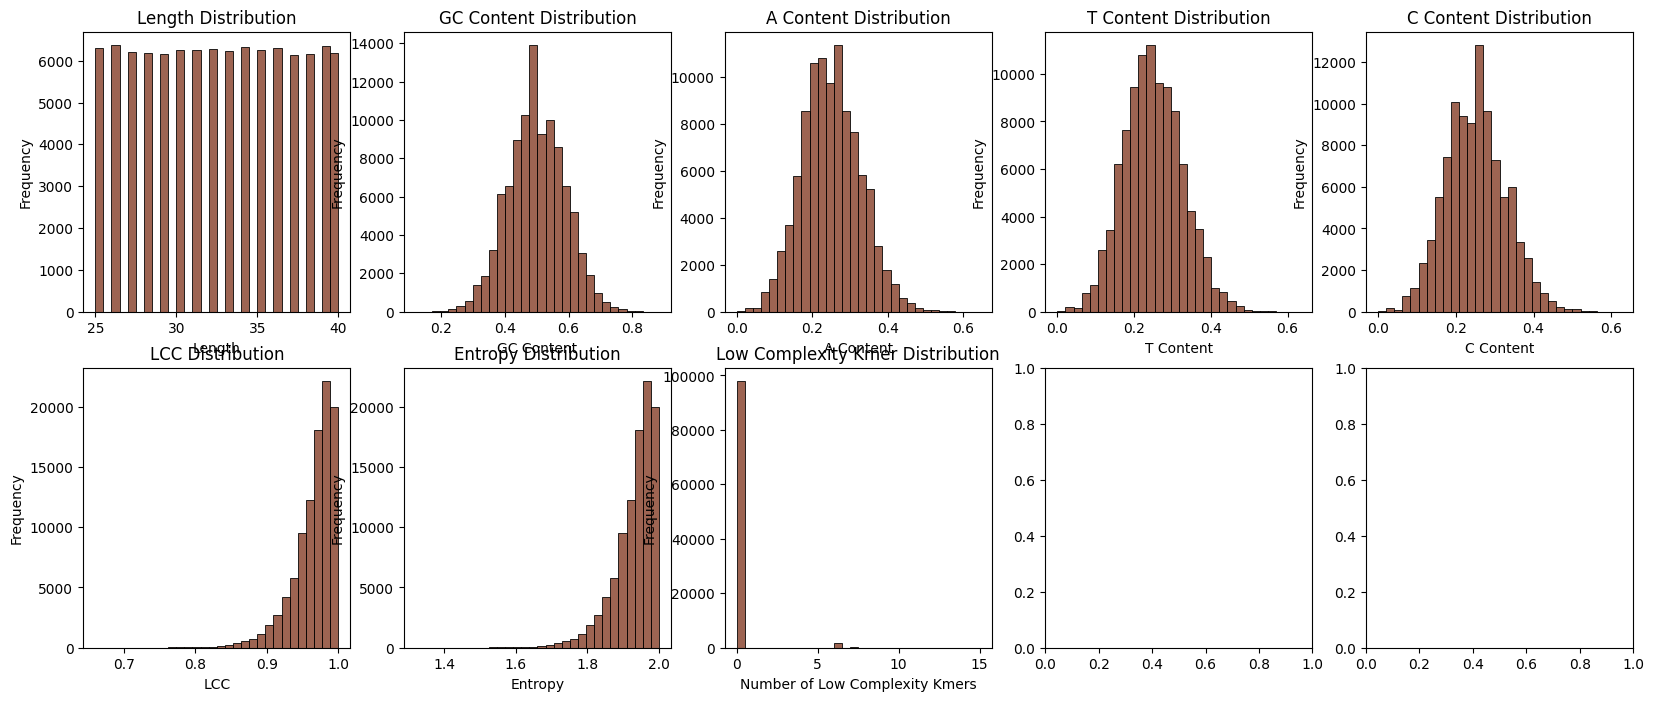

In [ ]:
# quick multi facet plots for the simulated spacers (length, gc_frac, a_frac, t_frac, c_frac, g_frac, lcc, entropy, low_compx_n_masked)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot length distribution
sns.histplot(simulated_spacers_df, x="length", bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Length Distribution')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')

# Plot GC content distribution
sns.histplot(simulated_spacers_df, x="gc_frac", bins=30, ax=axes[0, 1])
axes[0, 1].set_title('GC Content Distribution')
axes[0, 1].set_xlabel('GC Content')
axes[0, 1].set_ylabel('Frequency')

# Plot A content distribution
sns.histplot(simulated_spacers_df, x="a_frac", bins=30, ax=axes[0, 2])
axes[0, 2].set_title('A Content Distribution')
axes[0, 2].set_xlabel('A Content')
axes[0, 2].set_ylabel('Frequency')

# Plot T content distribution
sns.histplot(simulated_spacers_df, x="t_frac", bins=30, ax=axes[0, 3])
axes[0, 3].set_title('T Content Distribution')
axes[0, 3].set_xlabel('T Content')
axes[0, 3].set_ylabel('Frequency')

# Plot C content distribution
sns.histplot(simulated_spacers_df, x="c_frac", bins=30, ax=axes[0, 4])
axes[0, 4].set_title('C Content Distribution')
axes[0, 4].set_xlabel('C Content')
axes[0, 4].set_ylabel('Frequency')

# Plot LCC distribution
sns.histplot(simulated_spacers_df, x="lcc", bins=30, ax=axes[1, 0])
axes[1, 0].set_title('LCC Distribution')
axes[1, 0].set_xlabel('LCC')
axes[1, 0].set_ylabel('Frequency')

# Plot entropy distribution
sns.histplot(simulated_spacers_df, x="entropy", bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Entropy Distribution')
axes[1, 1].set_xlabel('Entropy')
axes[1, 1].set_ylabel('Frequency')

# Plot low complexity kmer distribution WIP
sns.histplot(simulated_spacers_df, x="low_compx_n_masked", bins=30, ax=axes[1, 2])
axes[1, 2].set_title('Low Complexity Kmer Distribution')
axes[1, 2].set_xlabel('Number of Low Complexity Kmers')
axes[1, 2].set_ylabel('Frequency')

# Plot kmer counts distribution WIP
sns.histplot(simulated_spacers_df, x="kmer_2_counts", bins=30, ax=axes[1, 3])
axes[1, 3].set_title('Kmer Counts Distribution')
axes[1, 3].set_xlabel('Number of Kmers')
axes[1, 3].set_ylabel('Frequency')



We'll further curate the spacer set by filtering out very low complexity sequences:  
- no more than 10% of the spacer is Ns
- no 6mers found more than 3 times.
- no 5mers found more than 5 times.
- All bases are A, T, C, or G must be present.
- Shannon entropy > 0.5
- pydustmasker with a window size of 5 and a score threshold of 18 has no masked bases.


(Next steps are in the subsampling notebook)

In [ ]:
# TODO: compare or test using this from bbtools:
# # kmercountshort.sh in=file.fa out=kcount.tsv k=5 skip=5 